### Scripts for hourly wind data processing and wind rose

#### Script for masking large nc file with bounding box shp file

In [ ]:
import xarray as xr
import geopandas as gpd
from shapely.geometry import mapping
from pathlib import Path
import rioxarray

def mask_nc_with_bbox_shapefile(input_nc_file, bbox_shapefile, pressure_level=1000):
    """
    Mask a NetCDF file using a polygon from a shapefile, identifies valid lat/lon coordinates in 'u' at valid_time=0,
    and uses those coordinates to filter the full dataset across all dimensions, then applies a final mask based on the shapefile.

    Parameters:
    - input_nc_file: Path to the input NetCDF file.
    - bbox_shapefile: Path to the shapefile containing the area of interest as polygons.
    - pressure_level: The pressure level to analyze (default is 1000 mb).

    Output:
    - Saves a single NetCDF file with the subset for the specified lat/lon coordinates within the shapefile extent
      (e.g., "input_filename_filtered.nc").
    """

    input_nc_path = Path(input_nc_file)

    if input_nc_path.exists():
        output_nc_file = input_nc_path.with_name(f"{input_nc_path.stem}_{Path(bbox_shapefile).stem}_masked.nc")
    else:
        raise FileNotFoundError(f"Input NetCDF file not found: {input_nc_file}")

    gdf = gpd.read_file(bbox_shapefile).to_crs("EPSG:4326")
    ds = xr.open_dataset(input_nc_file, chunks=None).sel(pressure_level=pressure_level).isel(valid_time=0)

    if not {'u', 'v'}.issubset(ds.variables):
       raise ValueError("The dataset must contain 'u' and 'v' variables.")

    ds = ds.rio.write_crs("EPSG:4326")
    clipped_ds = ds.rio.clip(gdf.geometry.apply(mapping), gdf.crs, drop=True)
    valid_points = clipped_ds['u'].where(~clipped_ds['u'].isnull(), drop=True)

    lat_indices = valid_points.latitude.to_index().values
    lon_indices = valid_points.longitude.to_index().values

    full_ds = xr.open_dataset(input_nc_file, engine='netcdf4')
    ds_filtered = full_ds.sel(latitude=lat_indices, longitude=lon_indices, method="nearest")
    ds_filtered = ds_filtered.rio.write_crs("EPSG:4326")
    ds_final = ds_filtered.rio.clip(gdf.geometry.apply(mapping), gdf.crs, drop=True)

    ds_final.to_netcdf(output_nc_file)
    print(f"Filtered data saved to {output_nc_file}")

input_nc_file = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\Daily_multilevel\Windir_1950_2024_Jan\data_stream-oper.nc"
# bbox_shapefile = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\BBox\BBox_small.shp"
bbox_shapefile = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\BBox\BBox_large.shp"

mask_nc_with_bbox_shapefile(input_nc_file, bbox_shapefile)

#### Script for generating binned wind direction from hourly counts using masked nc file

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path

def process_binned_wind_direction(input_nc_file, bin_size=15, cutoff_day=None, aggregation = "yearly"):
    """
    Processes ERA5 wind data to calculate the number of hours the wind falls within specific direction bins for each month.
    Wind direction is calculated in radians, converted to degrees for binning, and saved in a CSV with counts per direction bin.

    Parameters:
    - input_nc_file: Path to the input NetCDF file.
    - bin_size: Wind direction bin size in degrees (default is 15°).
    - cutoff_day: Limits data to days 1 through cutoff_day per month (default is None for full month).
    - aggregation: Defines the type of aggregation (yearly or 5-yearly).
    """

    ds = xr.open_dataset(input_nc_file, engine='netcdf4').squeeze("pressure_level", drop=True)
    times = pd.to_datetime(ds.get("valid_time", ds.get("time")).values)
    if cutoff_day:
        ds, times = ds.sel(valid_time=times.day <= cutoff_day), times[times.day <= cutoff_day]

    # Calculate wind direction in degrees
    median_u = ds['u'].median(dim=["latitude", "longitude"])
    median_v = ds['v'].median(dim=["latitude", "longitude"])
    mean_WD_deg = np.mod(270 + np.rad2deg(np.arctan2(median_u, median_v)), 360)

    df = pd.DataFrame({'year': times.year, 'month': times.month, 'wind_dir': mean_WD_deg}).dropna()
    bins = np.arange(0, 360 + bin_size, bin_size)
    df['wind_dir_bin'] = pd.cut(df['wind_dir'], bins=bins, labels=[f"{int(b)}-{int(b + bin_size)}" for b in bins[:-1]], right=False)

    if aggregation == "yearly":
        wind_direction_counts = df.groupby(['year', 'month', 'wind_dir_bin']).size().unstack(fill_value=0)
        output_csv_file = Path(input_nc_file).with_name(f"wind_direction_{bin_size}deg_{aggregation}_{Path(input_nc_file).stem}.csv")
    elif aggregation == "5-yearly":
        df['year'] = df['year'].apply(lambda y: f"{(y // 5) * 5}-{(y // 5) * 5 + 4}")
        wind_direction_counts = df.groupby(['year', 'month', 'wind_dir_bin']).size().unstack(fill_value=0)
        output_csv_file = Path(input_nc_file).with_name(f"wind_direction_{bin_size}deg_{aggregation}_{Path(input_nc_file).stem}.csv")
    else:
        raise ValueError("Invalid aggregation type. Use 'yearly' or '5-yearly'.")

    wind_direction_counts.to_csv(output_csv_file)
    print(f"Wind direction bin counts saved to {output_csv_file}")

# Example usage
input_nc_file = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\Daily_multilevel\Windir_1950_2024_Dec\data_stream-oper_BBox_small_masked.nc"
# input_nc_file = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\Daily_multilevel\Windir_1950_2024_Jan\data_stream-oper_BBox_large_masked.nc"
process_binned_wind_direction(input_nc_file, aggregation="5-yearly")


Wind direction bin counts saved to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Daily_multilevel\Windir_1950_2024_Jan\wind_direction_15deg_5-yearly_data_stream-oper_BBox_large_masked.csv


#### Script for generating wind rose charts using binned data

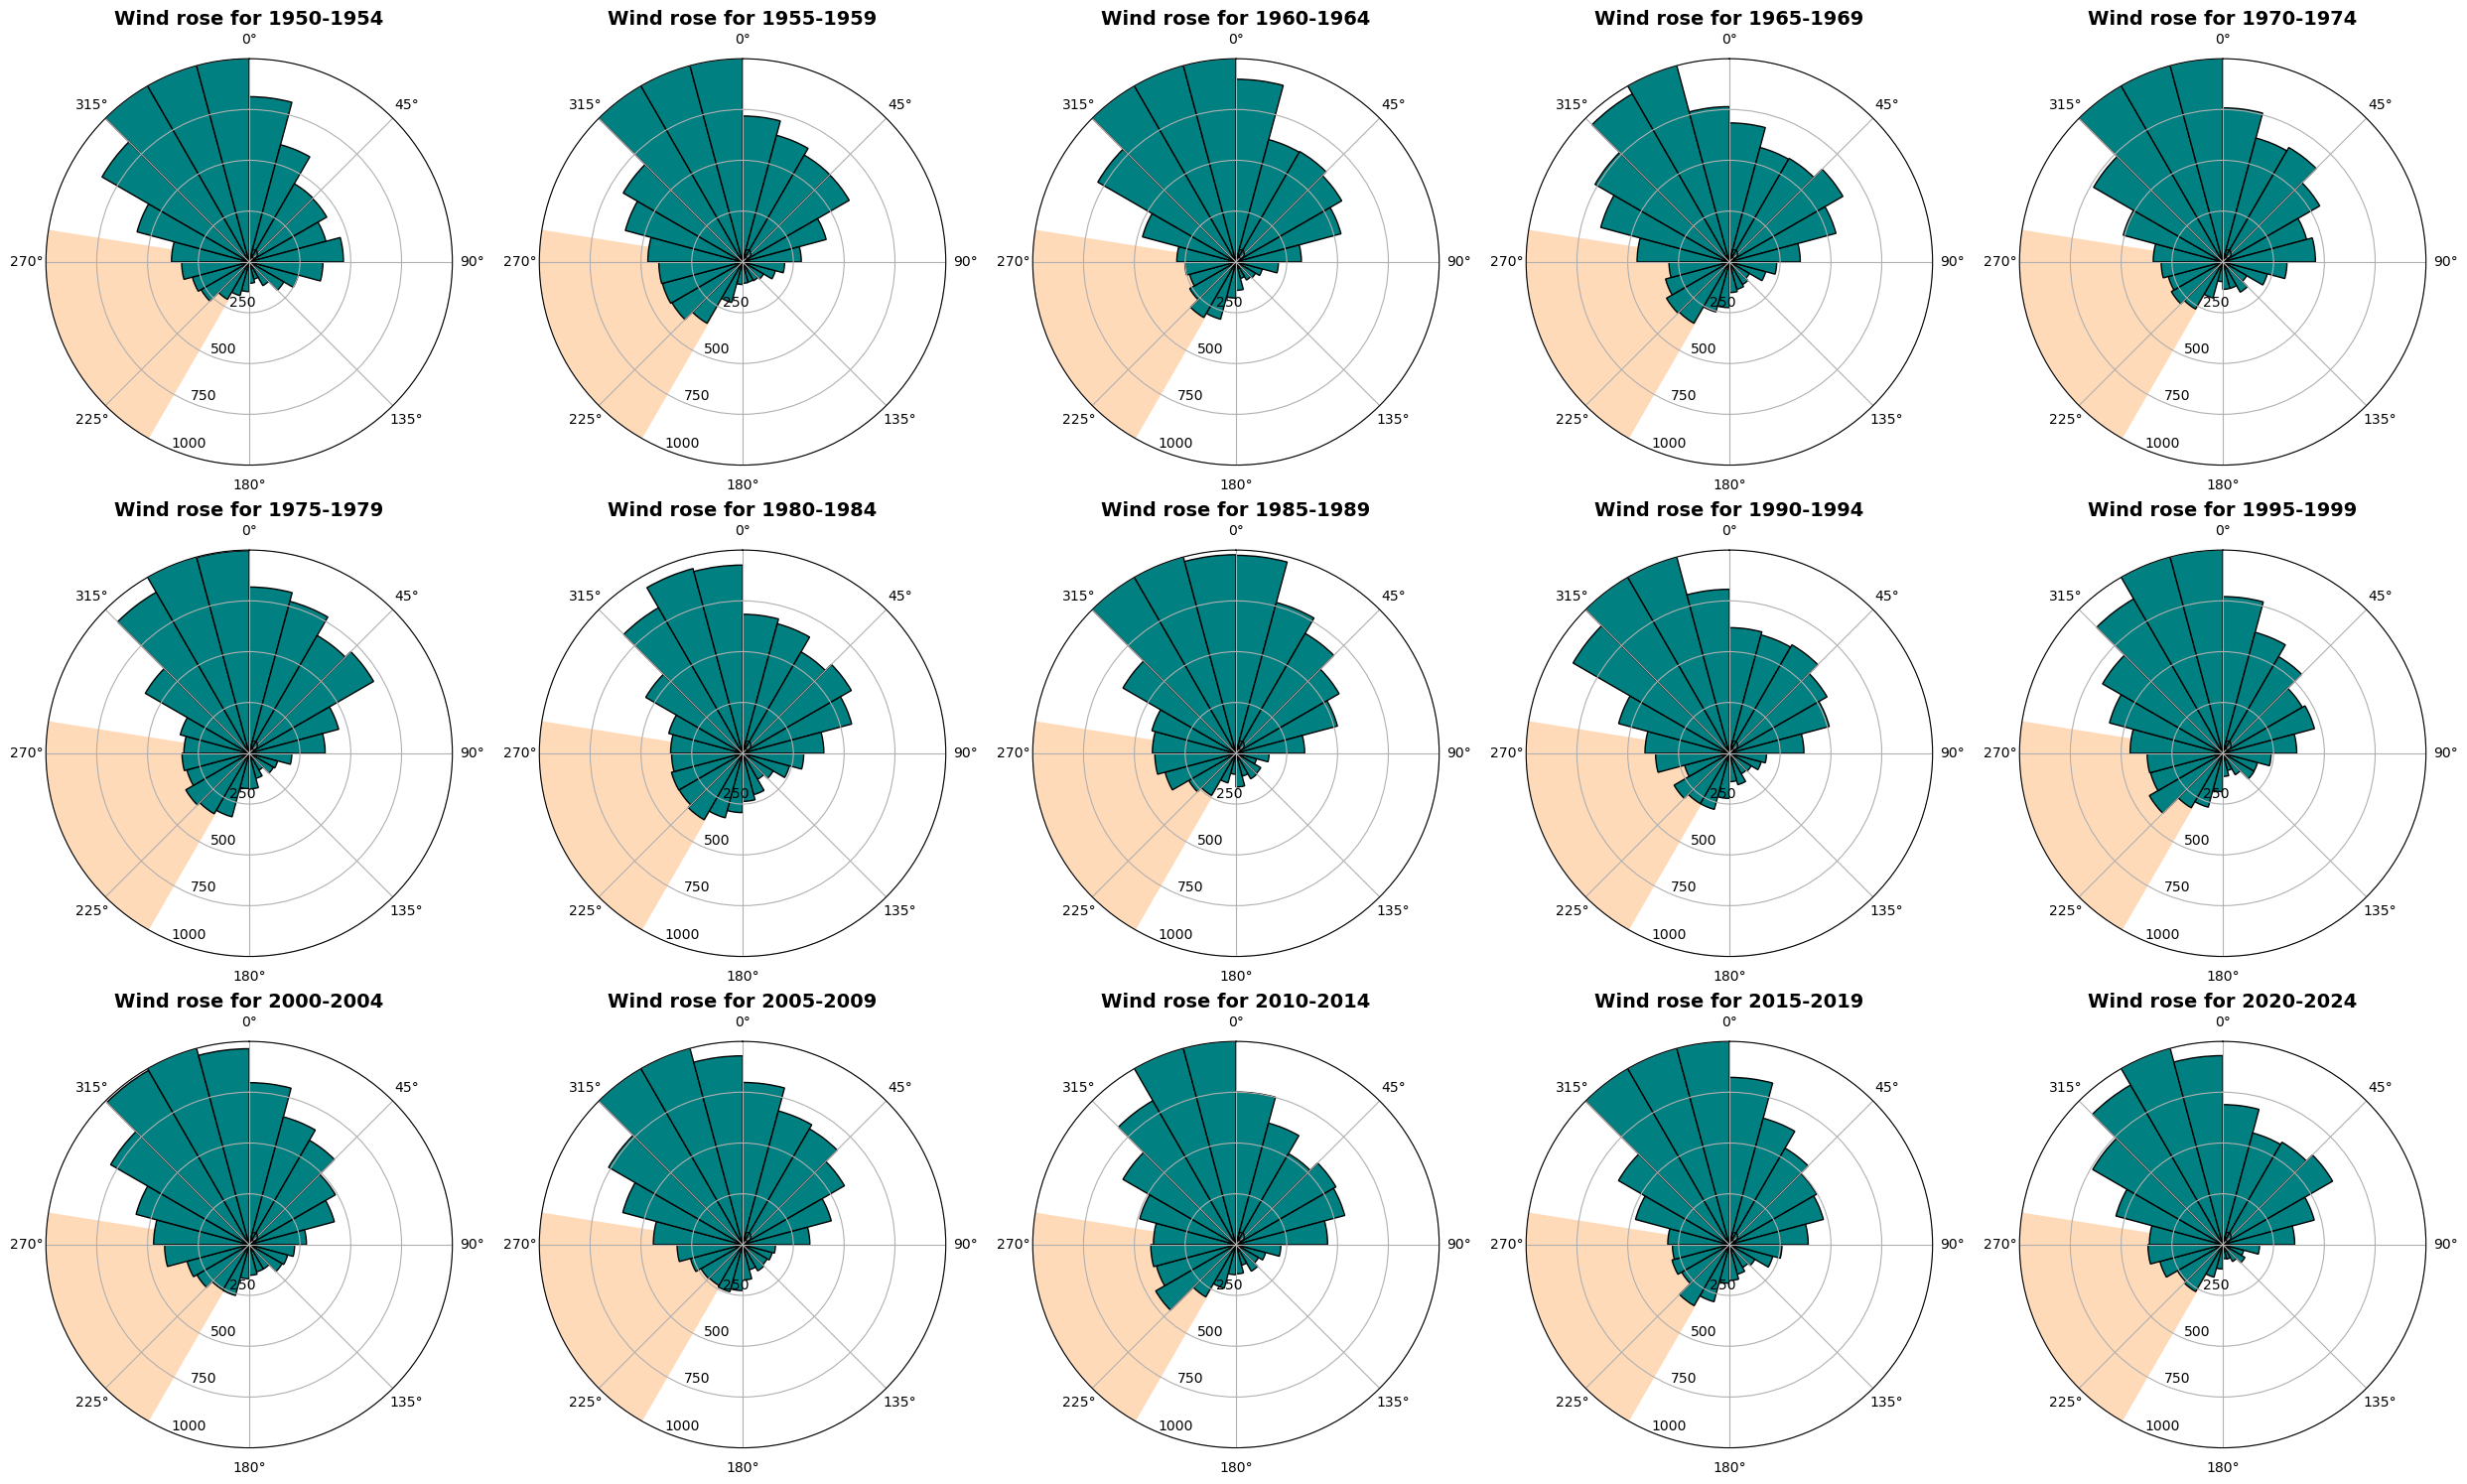

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_windrose_from_binned_data(csv_file, charts_per_row=10, max_rmax=None):
    """
    Reads wind direction data from a CSV file and generates wind rose plots, arranged by decades (10 charts per row).

    Parameters:
    - csv_file: Path to the input CSV file containing wind direction bin counts.
    - charts_per_row: Number of charts per row (default is 10).
    - max_rmax: The maximum radius for the polar plots (optional). If None, it will auto-scale based on data.
    """
    try:
        wind_data = pd.read_excel(csv_file, sheet_name="Sheet1")
        # wind_data = pd.read_csv(csv_file)
    except Exception as e:
        raise ValueError(f"Error loading CSV file: {e}")

    if 'year' not in wind_data.columns or 'month' not in wind_data.columns:
        raise ValueError("The input CSV must contain 'year' and 'month' columns.")

    direction_bin_columns = wind_data.columns.difference(['year', 'month'])
    frequency_by_bin = wind_data.set_index(['year', 'month'])[direction_bin_columns]

    if frequency_by_bin.empty:
        raise ValueError("No wind direction data found in the CSV file.")

    num_years = len(frequency_by_bin.index.get_level_values('year').unique())
    num_rows = (num_years // charts_per_row) + (1 if num_years % charts_per_row != 0 else 0)

    fig, axes = plt.subplots(num_rows, charts_per_row, subplot_kw=dict(projection='polar'),
                             figsize=(5 * charts_per_row, 5 * num_rows))
    axes = axes.flatten()

    angles = [np.radians((float(b.split('-')[0]) + float(b.split('-')[1])) / 2) for b in direction_bin_columns]
    manual_rmax = frequency_by_bin.values.max() * 1.1 if max_rmax is None else max_rmax

    axis_index = 0

    for index, data in frequency_by_bin.groupby(level=0):
        if index == "1945-1949": continue
        ax = axes[axis_index]
        start_angle, end_angle = np.radians(210), np.radians(279)
        ax.fill_between(np.linspace(start_angle, end_angle, 100), 0, manual_rmax, color='peachpuff')
        data = data.droplevel(0).squeeze()
        ax.bar(angles, data, width=np.radians(15), edgecolor='black', color='teal')
        ax.set_rmax(manual_rmax)
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        ax.set_rlabel_position(202.5)
        ax.set_title(f"Wind rose for {index}", fontsize=14, fontweight='bold')
        ax.set_rticks(np.linspace(0, manual_rmax, num=5))
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
        axis_index += 1

    for j in range(axis_index, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Example usage
csv_file_path = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\Daily_multilevel\Wind rose\wind_direction_15deg_5-yearly_DJF_ERA5_BBox_large_masked.xlsx"
plot_windrose_from_binned_data(csv_file_path, charts_per_row=5, max_rmax=1000)
# plot_windrose_from_binned_data(csv_file_path)


#### Script for making web map with wind roses

In [ ]:
import folium
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import base64
import pandas as pd

# Parameters
input_nc_file = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\Daily_multilevel\Windir_1950_2024_Jan\data_stream-oper_BBox_small.nc"
input_datetime = '2024-01-04 00:00:00'
averaging_period = 'hourly'  # Options: 'hourly', 'daily', 'monthly'
center, zoom, max_count = [50.04, -110.68], 9, 100

# Load dataset and select time period for averaging
ds = xr.open_dataset(input_nc_file, engine='netcdf4', chunks={'valid_time': 100})
ds['valid_time'] = pd.to_datetime(ds['valid_time'].values)
sel_time = pd.to_datetime(input_datetime)

if averaging_period == 'hourly':
    ds_sel = ds.sel(valid_time=sel_time, method='nearest')
elif averaging_period == 'daily':
    ds_sel = ds.sel(valid_time=slice(sel_time.normalize(), sel_time.normalize() + pd.Timedelta(days=1))).mean(dim='valid_time', skipna=True)
elif averaging_period == 'monthly':
    start, end = sel_time.replace(day=1), (sel_time.replace(day=1) + pd.DateOffset(months=1)) - pd.Timedelta(days=1)
    ds_sel = ds.sel(valid_time=slice(start, end)).mean(dim='valid_time', skipna=True)
else:
    raise ValueError("Invalid averaging period. Choose from 'hourly', 'daily', 'monthly'.")

# Extract wind components and calculate weighted wind direction
U, V = ds_sel['u'].values, ds_sel['v'].values
lats, lons = ds_sel['latitude'].values, ds_sel['longitude'].values
speed = np.sqrt(U**2 + V**2)
# V_east = speed * np.sin(np.arctan2(V, U))
# V_north = speed * np.cos(np.arctan2(V, U))
# direction = (180 + np.rad2deg(np.arctan2(V_east, V_north))) % 360
direction = np.mod(270 + np.rad2deg(np.arctan2(U, V)), 360)

# Function to create wind rose plot and return it as a base64 image
def create_wind_rose(direction, speed):
    if np.isnan(direction).all() or np.isnan(speed).all():
        return None
    wind_counts = np.clip(np.bincount(np.digitize(direction, np.arange(0, 361, 15)) - 1, minlength=24), 0, max_count)
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.bar(np.deg2rad(np.arange(0, 360, 15) + 7.5), wind_counts, width=np.deg2rad(15), color='teal', edgecolor='black')
    ax.set_yticklabels([])
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    return base64.b64encode(buf.getvalue()).decode()

# Create the Folium map
m = folium.Map(location=center, zoom_start=zoom)
for lat_idx, lat in enumerate(lats):
    for lon_idx, lon in enumerate(lons):
        dir_val = direction[lat_idx, lon_idx]
        spd_val = speed[lat_idx, lon_idx]

        if not np.isnan(dir_val) and not np.isnan(spd_val):
            wind_rose_img = create_wind_rose(np.array([dir_val]), np.array([spd_val]))
            if wind_rose_img:
                icon = folium.CustomIcon(f'data:image/png;base64,{wind_rose_img}', icon_size=(60, 60))
                folium.Marker(location=[lat, lon], icon=icon).add_to(m)

print(f"Successfully added {len(m._children)} wind roses.")
m


#### Tools to validate the equations

In [ ]:
import random
import pandas as pd
import numpy as np
import xarray as xr

def print_random_u_v(input_nc_file, num_random_dates=2):
    # Load dataset
    ds = xr.open_dataset(input_nc_file, engine='netcdf4').squeeze("pressure_level", drop=True)
    
    # Check dataset dimensions and coordinates
    print(f"Dimensions of u:\n{ds['u'].dims}")
    print(f"Coordinates of u:\n{ds['u'].coords}")
    
    # Get time information
    times = pd.to_datetime(ds['valid_time'].values)
    print(f"Time range: {times.min()} to {times.max()}")
    
    # Randomly choose 5 datetime indices
    random_dates = random.sample(range(len(times)), num_random_dates)
    
    # Loop through the random dates and print u, v, and lat-lon values
    for date_idx in random_dates:
        selected_time = times[date_idx]
        u_values = ds['u'].isel(valid_time=date_idx)  # Select u component at random time
        v_values = ds['v'].isel(valid_time=date_idx)  # Select v component at random time
        
        # Print values with datetime, lat-lon, u, v, wind direction in rad and deg
        latitudes = ds['latitude'].values
        longitudes = ds['longitude'].values
        
        # Create a DataFrame for better readability
        data = []
        for lat_idx in range(len(latitudes)):
            for lon_idx in range(len(longitudes)):
                u_value = u_values.isel(latitude=lat_idx, longitude=lon_idx).values
                v_value = v_values.isel(latitude=lat_idx, longitude=lon_idx).values
                
                # Wind direction calculation (radians and degrees)
                wind_direction_rad = np.arctan2(u_value, v_value)  # Using -u, -v for meteorological convention
                wind_direction_deg = np.mod(180 + np.rad2deg(wind_direction_rad), 360)
                
                data.append({
                    'datetime': selected_time,
                    'lat-lon': f"({latitudes[lat_idx]}, {longitudes[lon_idx]})",
                    'u': u_value,
                    'v': v_value,
                    'wind_direction_rad': wind_direction_rad,
                    'wind_direction_deg': wind_direction_deg
                })
        
        # Convert to DataFrame and print
        df = pd.DataFrame(data)
        print(df)
        print("-" * 50)

# Example usage
input_nc_file = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\Daily_multilevel\Windir_1950_2024_Jan\data_stream-oper_BBox_small_masked.nc"
print_random_u_v(input_nc_file)